## 1. Importations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import xgboost as xgb
from xgboost import XGBRegressor
import pickle
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
np.random.seed(42)

print("✅ Importations réussies!")

✅ Importations réussies!


## 2. Chargement et Exploration des Données

In [2]:
# Charger les données
df = pd.read_csv('combined_crypto_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Name', 'Date']).reset_index(drop=True)

print(f"📊 Dataset shape: {df.shape}")
print(f"📅 Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\n🪙 Cryptomonnaies: {df['Name'].unique()}")
print(f"\n📈 Statistiques des prix:")
print(df.groupby('Name')['Close'].describe())

# Afficher les premières lignes
df.head()

📊 Dataset shape: (5151, 10)
📅 Date range: 2013-04-29 23:59:59 to 2021-07-06 23:59:59

🪙 Cryptomonnaies: ['Bitcoin' 'Ethereum']

📈 Statistiques des prix:
           count         mean           std        min         25%  \
Name                                                                 
Bitcoin   2991.0  6711.290443  11298.141921  68.431000  430.569489   
Ethereum  2160.0   383.910691    601.078766   0.434829   13.819200   

                  50%          75%           max  
Name                                              
Bitcoin   2286.409912  8576.238715  63503.457930  
Ethereum   198.643691   386.435272   4168.701049  


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


## 3. Feature Engineering - Technical Indicators

In [3]:
print("🔧 Feature Engineering en cours...\n")

# === TIME-BASED FEATURES ===
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Quarter'] = df['Date'].dt.quarter

# === PRICE-BASED FEATURES ===
df['Price_Range'] = df['High'] - df['Low']
df['Price_Change'] = df['Close'] - df['Open']
df['Price_Change_Pct'] = (df['Price_Change'] / df['Open']) * 100

# === LAG FEATURES (Previous prices) ===
for lag in [1, 2, 3, 5, 7]:
    df[f'Close_Lag{lag}'] = df.groupby('Name')['Close'].shift(lag)

# === MOVING AVERAGES ===
for window in [7, 20, 30, 50]:
    df[f'MA_{window}'] = df.groupby('Name')['Close'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )

df['MA_Ratio_7_30'] = df['MA_7'] / df['MA_30']
df['Price_to_MA7'] = (df['Close'] - df['MA_7']) / df['MA_7'] * 100
df['Price_to_MA30'] = (df['Close'] - df['MA_30']) / df['MA_30'] * 100

# === VOLATILITY ===
df['Volatility_7'] = df.groupby('Name')['Close'].transform(
    lambda x: x.rolling(window=7, min_periods=1).std()
)
df['Volatility_30'] = df.groupby('Name')['Close'].transform(
    lambda x: x.rolling(window=30, min_periods=1).std()
)

# === RSI (Relative Strength Index) ===
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period, min_periods=1).mean()
    rs = gain / (loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_14'] = df.groupby('Name')['Close'].transform(lambda x: calculate_rsi(x, 14))

# === MACD (Moving Average Convergence Divergence) ===
def calculate_macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, min_periods=1, adjust=False).mean()
    ema_slow = series.ewm(span=slow, min_periods=1, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, min_periods=1, adjust=False).mean()
    return macd_line, signal_line

for crypto in df['Name'].unique():
    mask = df['Name'] == crypto
    macd, signal = calculate_macd(df.loc[mask, 'Close'])
    df.loc[mask, 'MACD'] = macd.values
    df.loc[mask, 'MACD_Signal'] = signal.values
    df.loc[mask, 'MACD_Hist'] = (macd - signal).values

# === BOLLINGER BANDS ===
df['BB_Middle'] = df.groupby('Name')['Close'].transform(
    lambda x: x.rolling(window=20, min_periods=1).mean()
)
df['BB_Std'] = df.groupby('Name')['Close'].transform(
    lambda x: x.rolling(window=20, min_periods=1).std()
)
df['BB_Upper'] = df['BB_Middle'] + (2 * df['BB_Std'])
df['BB_Lower'] = df['BB_Middle'] - (2 * df['BB_Std'])
df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / (df['BB_Middle'] + 1e-10)

# === VOLUME INDICATORS ===
df['Volume_MA_7'] = df.groupby('Name')['Volume'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)
df['Volume_Ratio'] = df['Volume'] / (df['Volume_MA_7'] + 1e-10)

# === MOMENTUM ===
df['ROC_5'] = df.groupby('Name')['Close'].transform(
    lambda x: ((x - x.shift(5)) / (x.shift(5) + 1e-10)) * 100
)
df['ROC_10'] = df.groupby('Name')['Close'].transform(
    lambda x: ((x - x.shift(10)) / (x.shift(10) + 1e-10)) * 100
)

# === ATR (Average True Range) ===
df['ATR_14'] = df.groupby('Name')['Price_Range'].transform(
    lambda x: x.rolling(window=14, min_periods=1).mean()
)

print("✅ Feature Engineering terminé!")
print(f"\n📊 Nombre de features: {len(df.columns)}")
print(f"\n🔍 Features créées:")
feature_cols = [col for col in df.columns if col not in ['SNo', 'Name', 'Symbol', 'Date', 'Marketcap']]
print(feature_cols)

🔧 Feature Engineering en cours...

✅ Feature Engineering terminé!

📊 Nombre de features: 45

🔍 Features créées:
['High', 'Low', 'Open', 'Close', 'Volume', 'Year', 'Month', 'DayOfWeek', 'Quarter', 'Price_Range', 'Price_Change', 'Price_Change_Pct', 'Close_Lag1', 'Close_Lag2', 'Close_Lag3', 'Close_Lag5', 'Close_Lag7', 'MA_7', 'MA_20', 'MA_30', 'MA_50', 'MA_Ratio_7_30', 'Price_to_MA7', 'Price_to_MA30', 'Volatility_7', 'Volatility_30', 'RSI_14', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Middle', 'BB_Std', 'BB_Upper', 'BB_Lower', 'BB_Width', 'Volume_MA_7', 'Volume_Ratio', 'ROC_5', 'ROC_10', 'ATR_14']


## 4. Création de la Target Variable (Prix du Lendemain)

In [4]:
# === TARGET: Prix de clôture du LENDEMAIN ===
df['Next_Close'] = df.groupby('Name')['Close'].shift(-1)

# Supprimer la dernière ligne de chaque crypto (pas de valeur future)
df = df[df['Next_Close'].notna()].copy()

print("🎯 Target Variable créée: Next_Close (prix de demain)")
print(f"\n📊 Dataset après suppression des NaN: {df.shape}")
print(f"\n💰 Statistiques de la target:")
print(df.groupby('Name')['Next_Close'].describe())

🎯 Target Variable créée: Next_Close (prix de demain)

📊 Dataset après suppression des NaN: (5149, 46)

💰 Statistiques de la target:
           count         mean           std        min         25%  \
Name                                                                 
Bitcoin   2990.0  6713.486681  11299.393126  68.431000  430.918991   
Ethereum  2159.0   384.088161    601.161412   0.434829   13.841400   

                  50%          75%           max  
Name                                              
Bitcoin   2295.694946  8577.107248  63503.457930  
Ethereum   198.872000   386.445556   4168.701049  


## 5. Préparation Train/Test avec Time-Series Split

In [5]:
# Séparer BTC et ETH
df_btc = df[df['Name'] == 'Bitcoin'].copy()
df_eth = df[df['Name'] == 'Ethereum'].copy()

# Features à utiliser
feature_cols = ['Close', 'Open', 'High', 'Low', 'Volume',
                'Price_Range', 'Price_Change', 'Price_Change_Pct',
                'Close_Lag1', 'Close_Lag2', 'Close_Lag3', 'Close_Lag5', 'Close_Lag7',
                'MA_7', 'MA_20', 'MA_30', 'MA_50',
                'MA_Ratio_7_30', 'Price_to_MA7', 'Price_to_MA30',
                'Volatility_7', 'Volatility_30',
                'RSI_14', 'MACD', 'MACD_Signal', 'MACD_Hist',
                'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width',
                'Volume_MA_7', 'Volume_Ratio',
                'ROC_5', 'ROC_10', 'ATR_14',
                'Year', 'Month', 'DayOfWeek', 'Quarter']

def prepare_data(df_crypto, crypto_name):
    # Supprimer les NaN
    df_clean = df_crypto.dropna(subset=feature_cols + ['Next_Close'])
    
    X = df_clean[feature_cols].values
    y = df_clean['Next_Close'].values
    dates = df_clean['Date'].values
    
    # Split chronologique: 80% train, 20% test
    split_idx = int(len(X) * 0.8)
    
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    dates_train, dates_test = dates[:split_idx], dates[split_idx:]
    
    # Normalisation
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"\n{'='*60}")
    print(f"🪙 {crypto_name}")
    print(f"{'='*60}")
    print(f"📊 Train: {X_train.shape[0]} samples | Test: {X_test.shape[0]} samples")
    print(f"📅 Train period: {dates_train[0]} → {dates_train[-1]}")
    print(f"📅 Test period: {dates_test[0]} → {dates_test[-1]}")
    print(f"💰 Train price range: ${y_train.min():.2f} - ${y_train.max():.2f}")
    print(f"💰 Test price range: ${y_test.min():.2f} - ${y_test.max():.2f}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, dates_test, scaler

# Préparer les données
X_train_btc, X_test_btc, y_train_btc, y_test_btc, dates_test_btc, scaler_btc = prepare_data(df_btc, 'Bitcoin')
X_train_eth, X_test_eth, y_train_eth, y_test_eth, dates_test_eth, scaler_eth = prepare_data(df_eth, 'Ethereum')

print(f"\n✅ Données préparées pour le training!")


🪙 Bitcoin
📊 Train: 2384 samples | Test: 596 samples
📅 Train period: 2013-05-09T23:59:59.000000000 → 2019-11-17T23:59:59.000000000
📅 Test period: 2019-11-18T23:59:59.000000000 → 2021-07-05T23:59:59.000000000
💰 Train price range: $68.43 - $19497.40
💰 Test price range: $4970.79 - $63503.46

🪙 Ethereum
📊 Train: 1719 samples | Test: 430 samples
📅 Train period: 2015-08-18T23:59:59.000000000 → 2020-05-01T23:59:59.000000000
📅 Test period: 2020-05-02T23:59:59.000000000 → 2021-07-05T23:59:59.000000000
💰 Train price range: $0.43 - $1396.42
💰 Test price range: $185.91 - $4168.70

✅ Données préparées pour le training!


## 6. Optimized Ridge Regression Model with Hyperparameter Tuning

In [6]:
from sklearn.model_selection import GridSearchCV

def train_optimized_ridge(X_train, X_test, y_train, y_test, crypto_name):
    """
    Train Ridge Regression with GridSearch hyperparameter optimization
    """
    print(f"\n{'='*70}")
    print(f"🤖 TRAINING OPTIMIZED RIDGE REGRESSION - {crypto_name}")
    print(f"{'='*70}\n")
    
    # Define hyperparameter grid for Ridge
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 50.0, 100.0],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga'],
        'fit_intercept': [True, False],
        'tol': [1e-3, 1e-4, 1e-5]
    }
    
    print("🔍 Starting GridSearchCV for hyperparameter optimization...")
    print(f"   Testing {len(param_grid['alpha']) * len(param_grid['solver']) * len(param_grid['fit_intercept']) * len(param_grid['tol'])} combinations")
    
    # Create Ridge model
    ridge = Ridge(random_state=42)
    
    # GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(
        estimator=ridge,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print(f"\n✅ Best Parameters Found:")
    for param, value in best_params.items():
        print(f"   • {param}: {value}")
    
    # Make predictions
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    
    # Calculate metrics for train set
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    train_r2 = r2_score(y_train, y_pred_train)
    train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    
    # Calculate metrics for test set
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_r2 = r2_score(y_test, y_pred_test)
    test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
    
    print(f"\n📊 Training Set Performance:")
    print(f"   MAE:  ${train_mae:,.2f}")
    print(f"   RMSE: ${train_rmse:,.2f}")
    print(f"   R²:   {train_r2:.6f}")
    print(f"   MAPE: {train_mape:.2f}%")
    
    print(f"\n📊 Test Set Performance:")
    print(f"   MAE:  ${test_mae:,.2f}")
    print(f"   RMSE: ${test_rmse:,.2f}")
    print(f"   R²:   {test_r2:.6f}")
    print(f"   MAPE: {test_mape:.2f}%")
    
    # Check for overfitting
    r2_diff = abs(train_r2 - test_r2)
    if r2_diff < 0.05:
        print(f"\n✅ Model Generalization: EXCELLENT (R² difference: {r2_diff:.4f})")
    elif r2_diff < 0.10:
        print(f"\n✅ Model Generalization: GOOD (R² difference: {r2_diff:.4f})")
    else:
        print(f"\n⚠️ Model Generalization: Potential overfitting (R² difference: {r2_diff:.4f})")
    
    results = {
        'model': best_model,
        'predictions': y_pred_test,
        'best_params': best_params,
        'metrics': {
            'train_mae': train_mae,
            'train_rmse': train_rmse,
            'train_r2': train_r2,
            'train_mape': train_mape,
            'test_mae': test_mae,
            'test_rmse': test_rmse,
            'test_r2': test_r2,
            'test_mape': test_mape
        }
    }
    
    return results

# Train optimized Ridge models
print("🚀 Training Optimized Ridge Regression Models...\n")
results_btc = train_optimized_ridge(X_train_btc, X_test_btc, y_train_btc, y_test_btc, 'Bitcoin')
results_eth = train_optimized_ridge(X_train_eth, X_test_eth, y_train_eth, y_test_eth, 'Ethereum')

# Extract models for easy access
model_btc = results_btc['model']
model_eth = results_eth['model']

print(f"\n{'='*70}")
print("✅ OPTIMIZATION COMPLETE!")
print(f"{'='*70}")
print(f"\n🏆 Bitcoin Model - Test R²: {results_btc['metrics']['test_r2']:.6f}")
print(f"🏆 Ethereum Model - Test R²: {results_eth['metrics']['test_r2']:.6f}")

🚀 Training Optimized Ridge Regression Models...


🤖 TRAINING OPTIMIZED RIDGE REGRESSION - Bitcoin

🔍 Starting GridSearchCV for hyperparameter optimization...
   Testing 300 combinations
Fitting 5 folds for each of 300 candidates, totalling 1500 fits

✅ Best Parameters Found:
   • alpha: 0.001
   • fit_intercept: True
   • solver: lsqr
   • tol: 0.001

📊 Training Set Performance:
   MAE:  $100.73
   RMSE: $245.29
   R²:   0.995763
   MAPE: 4.28%

📊 Test Set Performance:
   MAE:  $695.57
   RMSE: $1,265.31
   R²:   0.994749
   MAPE: 2.83%

✅ Model Generalization: EXCELLENT (R² difference: 0.0010)

🤖 TRAINING OPTIMIZED RIDGE REGRESSION - Ethereum

🔍 Starting GridSearchCV for hyperparameter optimization...
   Testing 300 combinations
Fitting 5 folds for each of 300 candidates, totalling 1500 fits

✅ Best Parameters Found:
   • alpha: 0.01
   • fit_intercept: True
   • solver: saga
   • tol: 0.001

📊 Training Set Performance:
   MAE:  $9.01
   RMSE: $18.82
   R²:   0.993585
   MAPE: 25.63%


## 7. Performance Visualization - Train vs Test

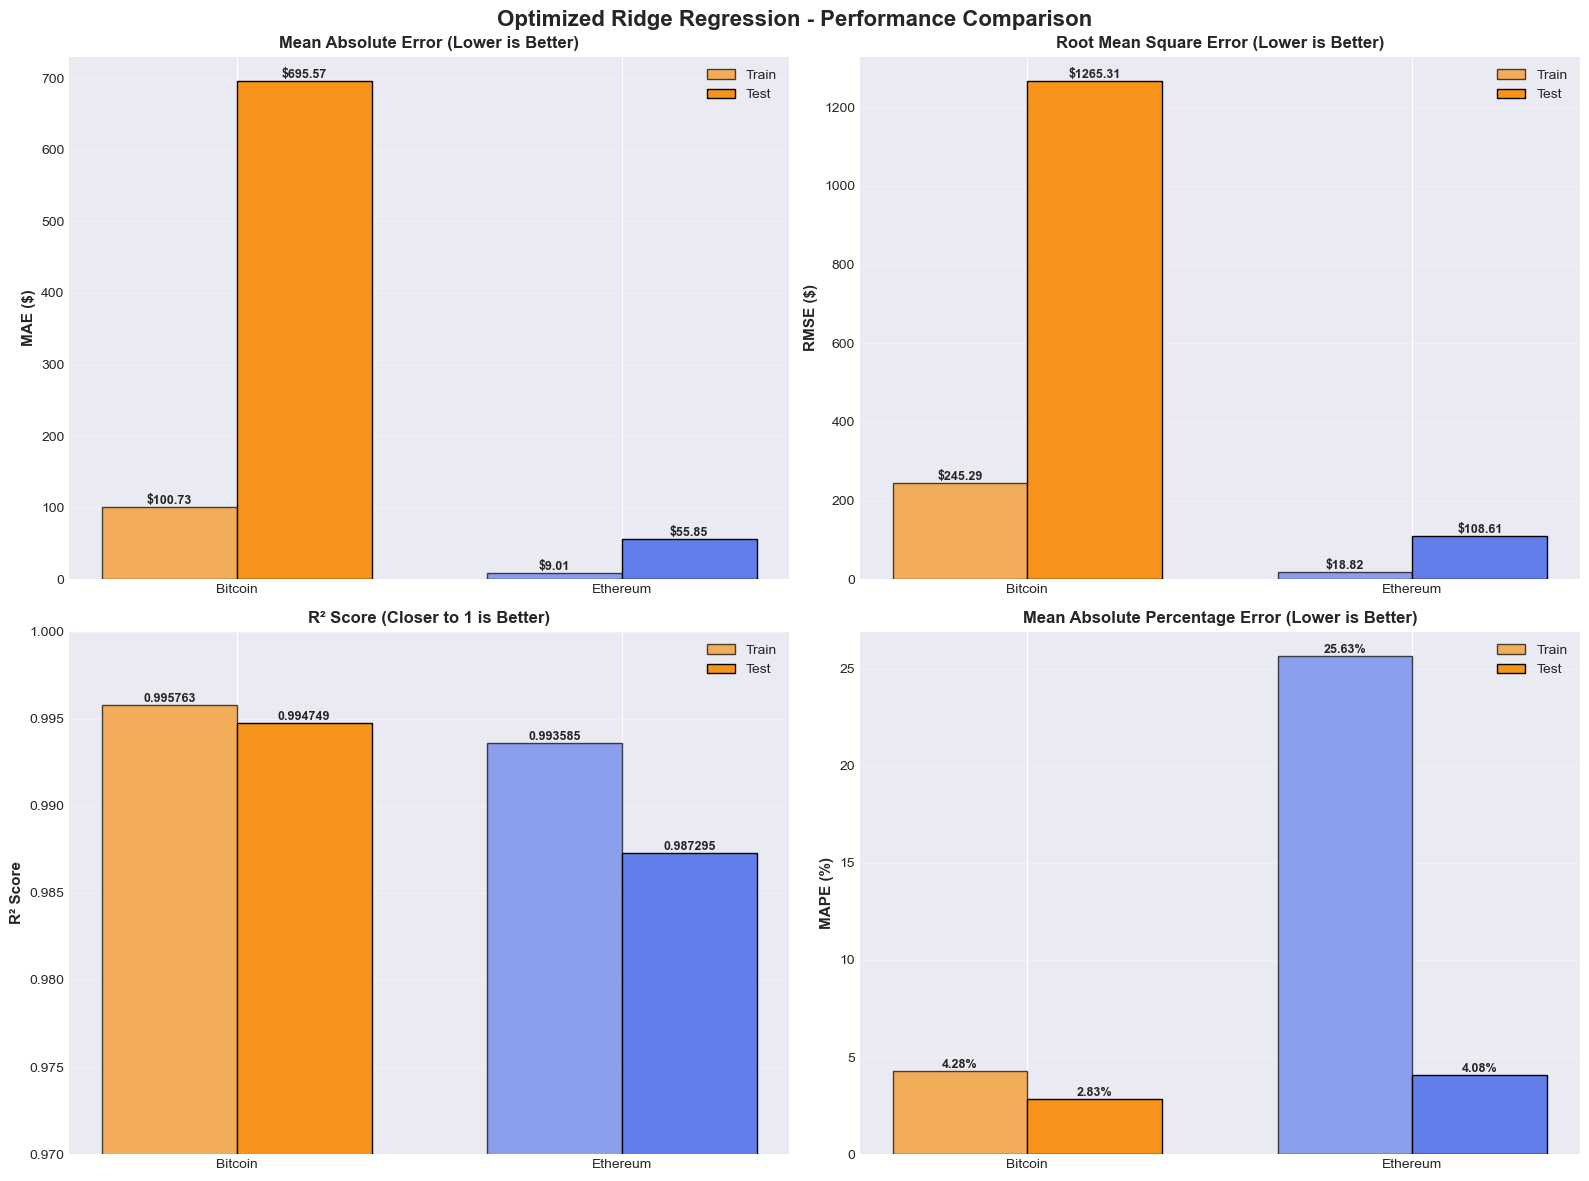


📊 DETAILED PERFORMANCE METRICS - OPTIMIZED RIDGE REGRESSION
  Crypto Train MAE Test MAE Train R²  Test R² Test MAPE
 Bitcoin   $100.73  $695.57 0.995763 0.994749     2.83%
Ethereum     $9.01   $55.85 0.993585 0.987295     4.08%

🔧 OPTIMIZED HYPERPARAMETERS:

📈 Bitcoin Ridge Model:
   • alpha: 0.001
   • fit_intercept: True
   • solver: lsqr
   • tol: 0.001

📈 Ethereum Ridge Model:
   • alpha: 0.01
   • fit_intercept: True
   • solver: saga
   • tol: 0.001


In [7]:
def visualize_ridge_performance(results_btc, results_eth):
    """Visualize optimized Ridge model performance"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Optimized Ridge Regression - Performance Comparison', fontsize=16, fontweight='bold')
    
    cryptos = ['Bitcoin', 'Ethereum']
    results = [results_btc, results_eth]
    colors = ['#F7931A', '#627EEA']
    
    # MAE Comparison
    ax = axes[0, 0]
    train_maes = [r['metrics']['train_mae'] for r in results]
    test_maes = [r['metrics']['test_mae'] for r in results]
    
    x = np.arange(len(cryptos))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, train_maes, width, label='Train', color=colors, alpha=0.7, edgecolor='black')
    bars2 = ax.bar(x + width/2, test_maes, width, label='Test', color=colors, alpha=1.0, edgecolor='black')
    
    ax.set_ylabel('MAE ($)', fontweight='bold', fontsize=11)
    ax.set_title('Mean Absolute Error (Lower is Better)', fontweight='bold', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(cryptos)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'${height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # RMSE Comparison
    ax = axes[0, 1]
    train_rmses = [r['metrics']['train_rmse'] for r in results]
    test_rmses = [r['metrics']['test_rmse'] for r in results]
    
    bars1 = ax.bar(x - width/2, train_rmses, width, label='Train', color=colors, alpha=0.7, edgecolor='black')
    bars2 = ax.bar(x + width/2, test_rmses, width, label='Test', color=colors, alpha=1.0, edgecolor='black')
    
    ax.set_ylabel('RMSE ($)', fontweight='bold', fontsize=11)
    ax.set_title('Root Mean Square Error (Lower is Better)', fontweight='bold', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(cryptos)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'${height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # R² Score Comparison
    ax = axes[1, 0]
    train_r2s = [r['metrics']['train_r2'] for r in results]
    test_r2s = [r['metrics']['test_r2'] for r in results]
    
    bars1 = ax.bar(x - width/2, train_r2s, width, label='Train', color=colors, alpha=0.7, edgecolor='black')
    bars2 = ax.bar(x + width/2, test_r2s, width, label='Test', color=colors, alpha=1.0, edgecolor='black')
    
    ax.set_ylabel('R² Score', fontweight='bold', fontsize=11)
    ax.set_title('R² Score (Closer to 1 is Better)', fontweight='bold', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(cryptos)
    ax.set_ylim([0.97, 1.0])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.6f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # MAPE Comparison
    ax = axes[1, 1]
    train_mapes = [r['metrics']['train_mape'] for r in results]
    test_mapes = [r['metrics']['test_mape'] for r in results]
    
    bars1 = ax.bar(x - width/2, train_mapes, width, label='Train', color=colors, alpha=0.7, edgecolor='black')
    bars2 = ax.bar(x + width/2, test_mapes, width, label='Test', color=colors, alpha=1.0, edgecolor='black')
    
    ax.set_ylabel('MAPE (%)', fontweight='bold', fontsize=11)
    ax.set_title('Mean Absolute Percentage Error (Lower is Better)', fontweight='bold', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(cryptos)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison table
    print(f"\n{'='*90}")
    print("📊 DETAILED PERFORMANCE METRICS - OPTIMIZED RIDGE REGRESSION")
    print(f"{'='*90}")
    
    comparison_data = []
    for crypto, result in zip(cryptos, results):
        comparison_data.append({
            'Crypto': crypto,
            'Train MAE': f"${result['metrics']['train_mae']:,.2f}",
            'Test MAE': f"${result['metrics']['test_mae']:,.2f}",
            'Train R²': f"{result['metrics']['train_r2']:.6f}",
            'Test R²': f"{result['metrics']['test_r2']:.6f}",
            'Test MAPE': f"{result['metrics']['test_mape']:.2f}%"
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    print(f"{'='*90}")
    
    # Best parameters summary
    print(f"\n🔧 OPTIMIZED HYPERPARAMETERS:")
    print(f"\n📈 Bitcoin Ridge Model:")
    for param, value in results_btc['best_params'].items():
        print(f"   • {param}: {value}")
    
    print(f"\n📈 Ethereum Ridge Model:")
    for param, value in results_eth['best_params'].items():
        print(f"   • {param}: {value}")

# Visualize performance
visualize_ridge_performance(results_btc, results_eth)

## 8. Visualisation: Prédictions vs Prix Réels

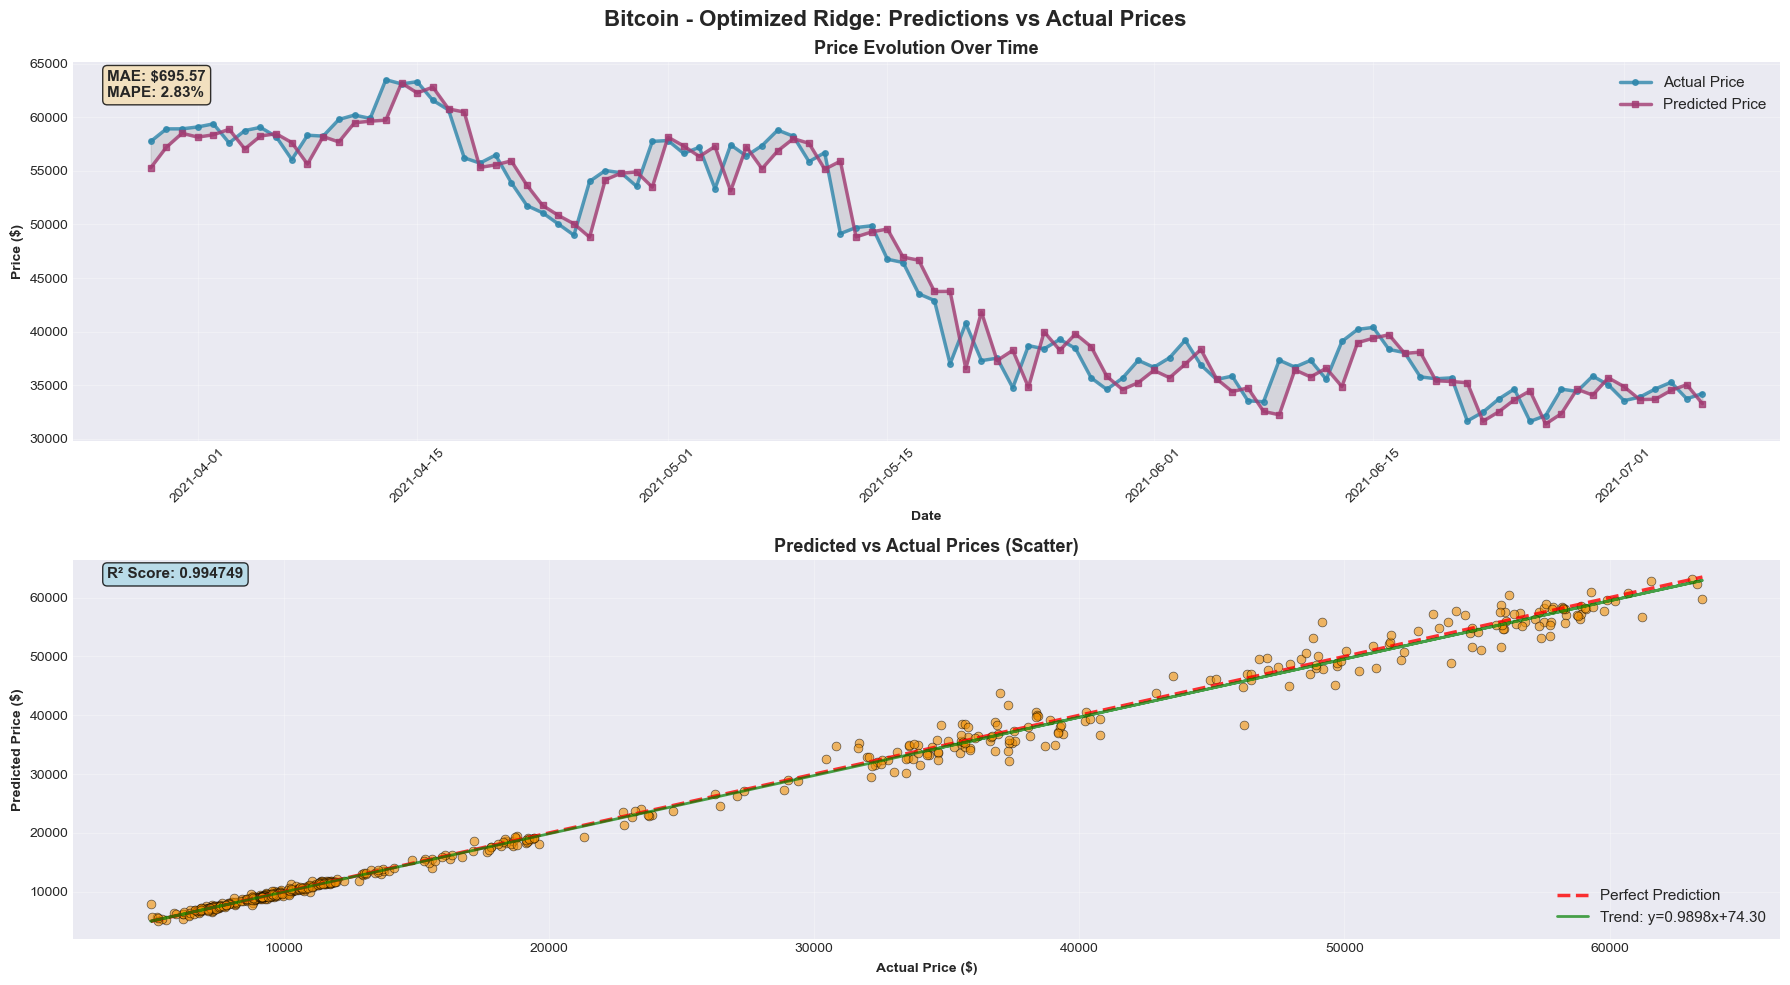

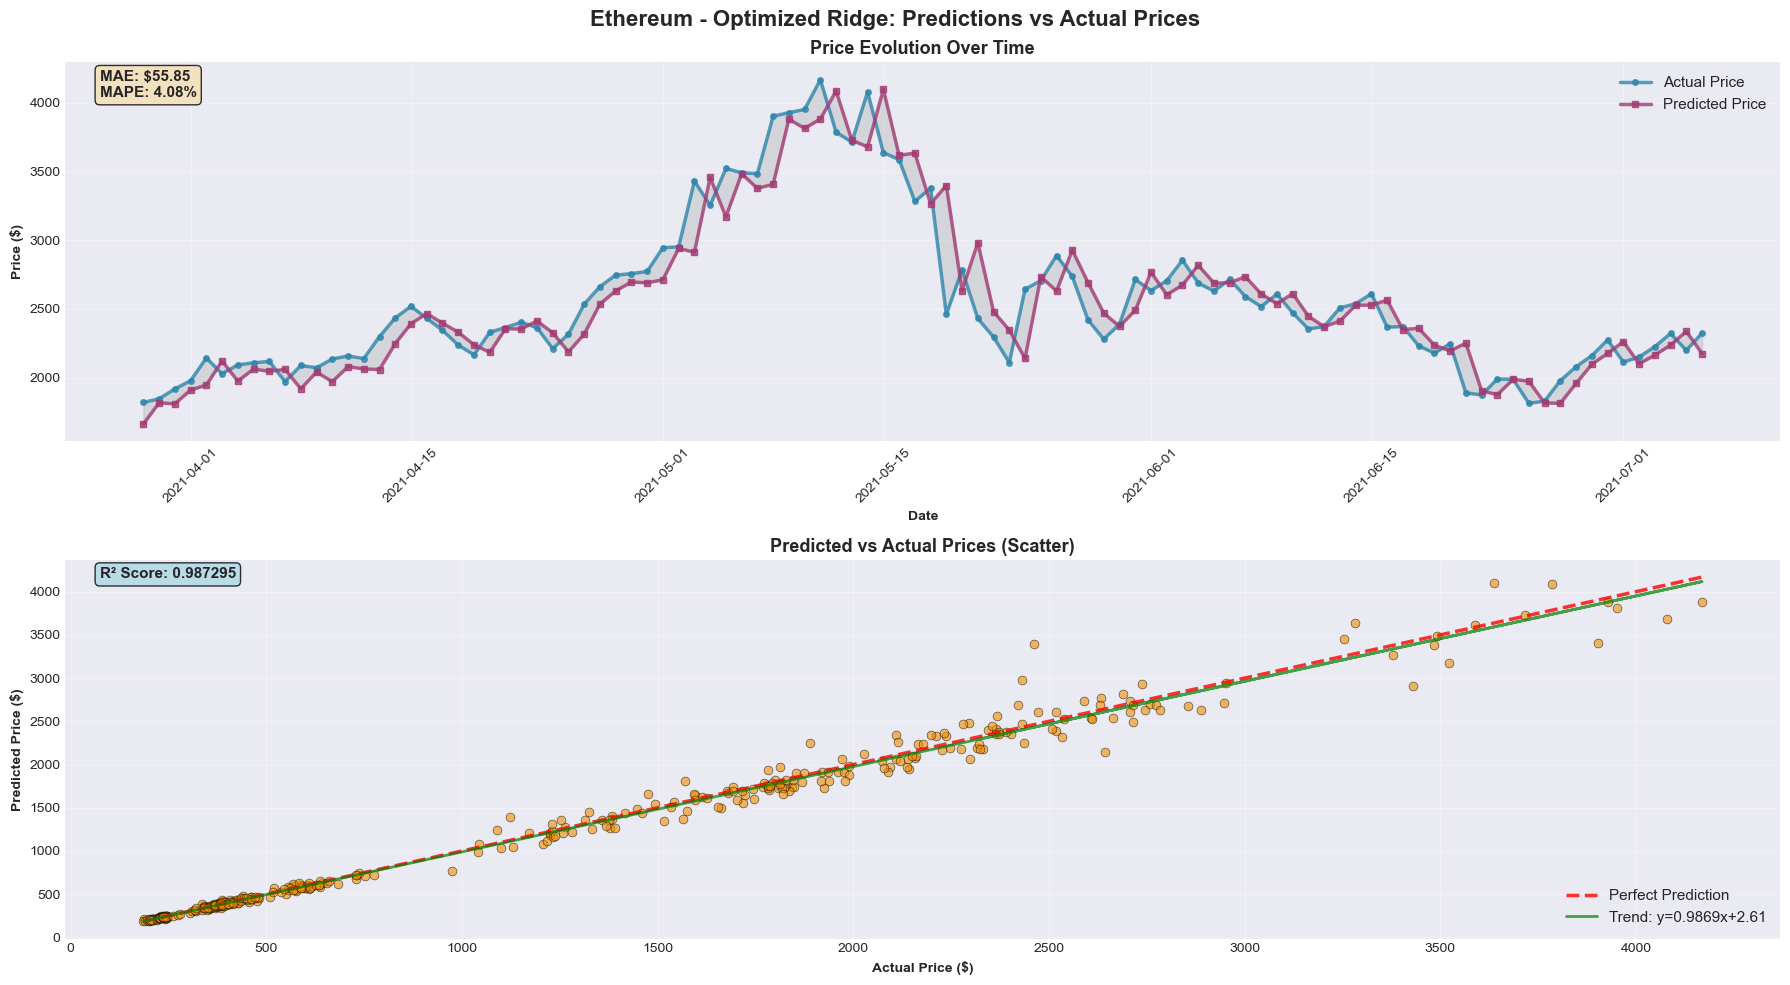

In [8]:
def plot_predictions_vs_actual(y_test, predictions, dates, crypto_name, sample_size=100):
    """Enhanced visualization with trend analysis"""
    # Take last samples
    y_test_sample = y_test[-sample_size:]
    pred_sample = predictions[-sample_size:]
    dates_sample = dates[-sample_size:]
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    
    fig, axes = plt.subplots(2, 1, figsize=(18, 10))
    fig.suptitle(f'{crypto_name} - Optimized Ridge: Predictions vs Actual Prices', 
                 fontsize=16, fontweight='bold')
    
    # Plot 1: Time series with trend line
    axes[0].plot(dates_sample, y_test_sample, label='Actual Price', 
                color='#2E86AB', linewidth=2.5, marker='o', markersize=4, alpha=0.8)
    axes[0].plot(dates_sample, pred_sample, label='Predicted Price', 
                color='#A23B72', linewidth=2.5, marker='s', markersize=4, alpha=0.8)
    axes[0].fill_between(dates_sample, y_test_sample, pred_sample, alpha=0.2, color='gray')
    
    axes[0].set_title('Price Evolution Over Time', fontweight='bold', fontsize=13)
    axes[0].set_xlabel('Date', fontweight='bold')
    axes[0].set_ylabel('Price ($)', fontweight='bold')
    axes[0].legend(loc='best', fontsize=11, framealpha=0.9)
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Add metrics text box
    textstr = f'MAE: ${mae:,.2f}\nMAPE: {mape:.2f}%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    axes[0].text(0.02, 0.98, textstr, transform=axes[0].transAxes, fontsize=11,
                verticalalignment='top', bbox=props, fontweight='bold')
    
    # Plot 2: Scatter plot with trend line
    axes[1].scatter(y_test, predictions, alpha=0.6, s=40, color='#F18F01', edgecolor='black', linewidth=0.5)
    
    # Perfect prediction line
    min_val = min(y_test.min(), predictions.min())
    max_val = max(y_test.max(), predictions.max())
    axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2.5, 
                label='Perfect Prediction', alpha=0.8)
    
    # Trend line
    z = np.polyfit(y_test, predictions, 1)
    p = np.poly1d(z)
    axes[1].plot(y_test, p(y_test), "g-", linewidth=2, label=f'Trend: y={z[0]:.4f}x+{z[1]:.2f}', alpha=0.7)
    
    axes[1].set_title('Predicted vs Actual Prices (Scatter)', fontweight='bold', fontsize=13)
    axes[1].set_xlabel('Actual Price ($)', fontweight='bold')
    axes[1].set_ylabel('Predicted Price ($)', fontweight='bold')
    axes[1].legend(loc='best', fontsize=11, framealpha=0.9)
    axes[1].grid(True, alpha=0.3)
    
    # Add R² text box
    textstr = f'R² Score: {r2:.6f}'
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
    axes[1].text(0.02, 0.98, textstr, transform=axes[1].transAxes, fontsize=11,
                verticalalignment='top', bbox=props, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions
plot_predictions_vs_actual(y_test_btc, results_btc['predictions'], dates_test_btc, 'Bitcoin')
plot_predictions_vs_actual(y_test_eth, results_eth['predictions'], dates_test_eth, 'Ethereum')

## 9. Analyse des Erreurs

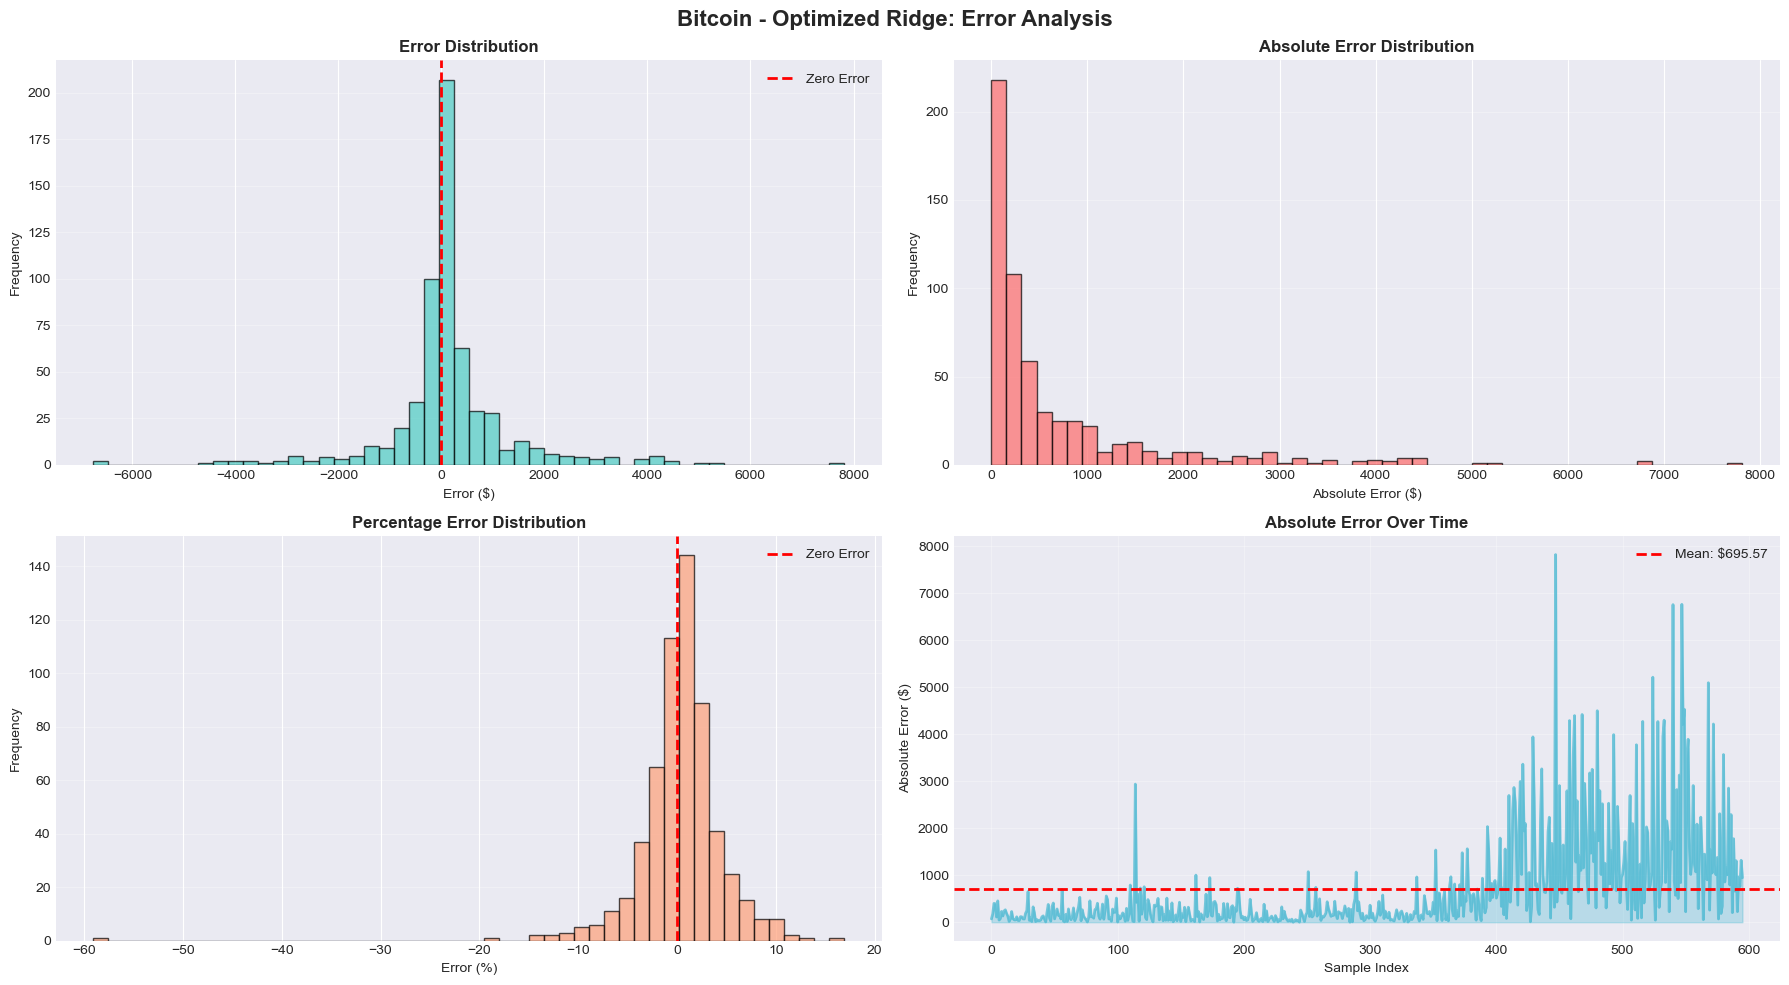


📊 ERROR STATISTICS - Bitcoin
Mean Error:           $145.84
Mean Absolute Error:  $695.57
Median Absolute Error:$251.66
Std Error:            $1,256.88
Max Over-prediction:  $7,818.95
Max Under-prediction: $-6,760.80

Mean % Error:         0.393%
Median % Error:       0.570%
Std % Error:          4.551%

📏 Error Distribution:
Within ±1%:  29.9%
Within ±2%:  52.7%
Within ±5%:  84.1%


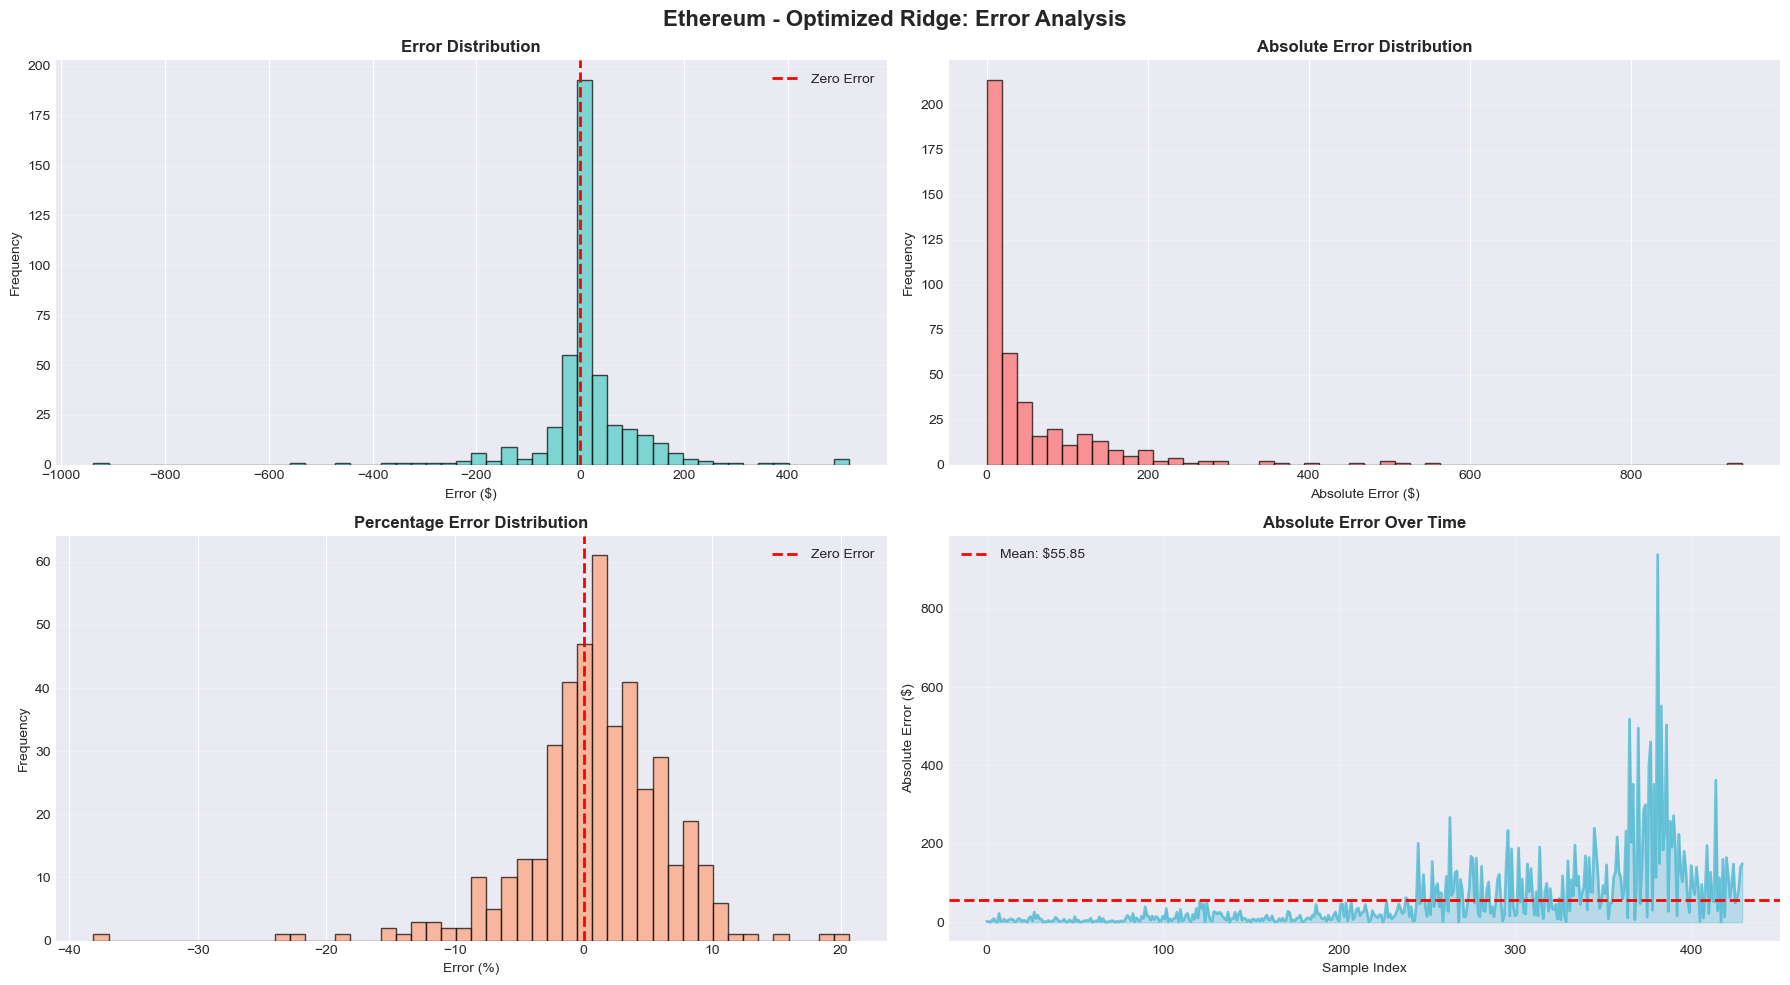


📊 ERROR STATISTICS - Ethereum
Mean Error:           $11.96
Mean Absolute Error:  $55.85
Median Absolute Error:$18.85
Std Error:            $107.95
Max Over-prediction:  $518.42
Max Under-prediction: $-937.90

Mean % Error:         1.008%
Median % Error:       1.167%
Std % Error:          5.631%

📏 Error Distribution:
Within ±1%:  18.6%
Within ±2%:  37.7%
Within ±5%:  69.3%


In [9]:
def analyze_errors(y_test, predictions, crypto_name):
    """Enhanced error analysis for Ridge model"""
    errors = y_test - predictions
    abs_errors = np.abs(errors)
    pct_errors = (errors / y_test) * 100
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    fig.suptitle(f'{crypto_name} - Optimized Ridge: Error Analysis', fontsize=16, fontweight='bold')
    
    # Error distribution
    axes[0, 0].hist(errors, bins=50, color='#4ECDC4', edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    axes[0, 0].set_title('Error Distribution', fontweight='bold', fontsize=12)
    axes[0, 0].set_xlabel('Error ($)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Absolute errors
    axes[0, 1].hist(abs_errors, bins=50, color='#FF6B6B', edgecolor='black', alpha=0.7)
    axes[0, 1].set_title('Absolute Error Distribution', fontweight='bold', fontsize=12)
    axes[0, 1].set_xlabel('Absolute Error ($)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Percentage errors
    axes[1, 0].hist(pct_errors, bins=50, color='#FFA07A', edgecolor='black', alpha=0.7)
    axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    axes[1, 0].set_title('Percentage Error Distribution', fontweight='bold', fontsize=12)
    axes[1, 0].set_xlabel('Error (%)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Error over time
    axes[1, 1].plot(abs_errors, color='#45B7D1', linewidth=2, alpha=0.7)
    axes[1, 1].axhline(y=abs_errors.mean(), color='red', linestyle='--', 
                       linewidth=2, label=f'Mean: ${abs_errors.mean():,.2f}')
    axes[1, 1].fill_between(range(len(abs_errors)), 0, abs_errors, alpha=0.3, color='#45B7D1')
    axes[1, 1].set_title('Absolute Error Over Time', fontweight='bold', fontsize=12)
    axes[1, 1].set_xlabel('Sample Index')
    axes[1, 1].set_ylabel('Absolute Error ($)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"\n{'='*70}")
    print(f"📊 ERROR STATISTICS - {crypto_name}")
    print(f"{'='*70}")
    print(f"Mean Error:           ${errors.mean():,.2f}")
    print(f"Mean Absolute Error:  ${abs_errors.mean():,.2f}")
    print(f"Median Absolute Error:${np.median(abs_errors):,.2f}")
    print(f"Std Error:            ${errors.std():,.2f}")
    print(f"Max Over-prediction:  ${errors.max():,.2f}")
    print(f"Max Under-prediction: ${errors.min():,.2f}")
    print(f"\nMean % Error:         {pct_errors.mean():.3f}%")
    print(f"Median % Error:       {np.median(pct_errors):.3f}%")
    print(f"Std % Error:          {pct_errors.std():.3f}%")
    
    # Error ranges
    print(f"\n📏 Error Distribution:")
    within_1_pct = (abs(pct_errors) <= 1).sum() / len(pct_errors) * 100
    within_2_pct = (abs(pct_errors) <= 2).sum() / len(pct_errors) * 100
    within_5_pct = (abs(pct_errors) <= 5).sum() / len(pct_errors) * 100
    print(f"Within ±1%:  {within_1_pct:.1f}%")
    print(f"Within ±2%:  {within_2_pct:.1f}%")
    print(f"Within ±5%:  {within_5_pct:.1f}%")

analyze_errors(y_test_btc, results_btc['predictions'], 'Bitcoin')
analyze_errors(y_test_eth, results_eth['predictions'], 'Ethereum')

## 10. Feature Importance

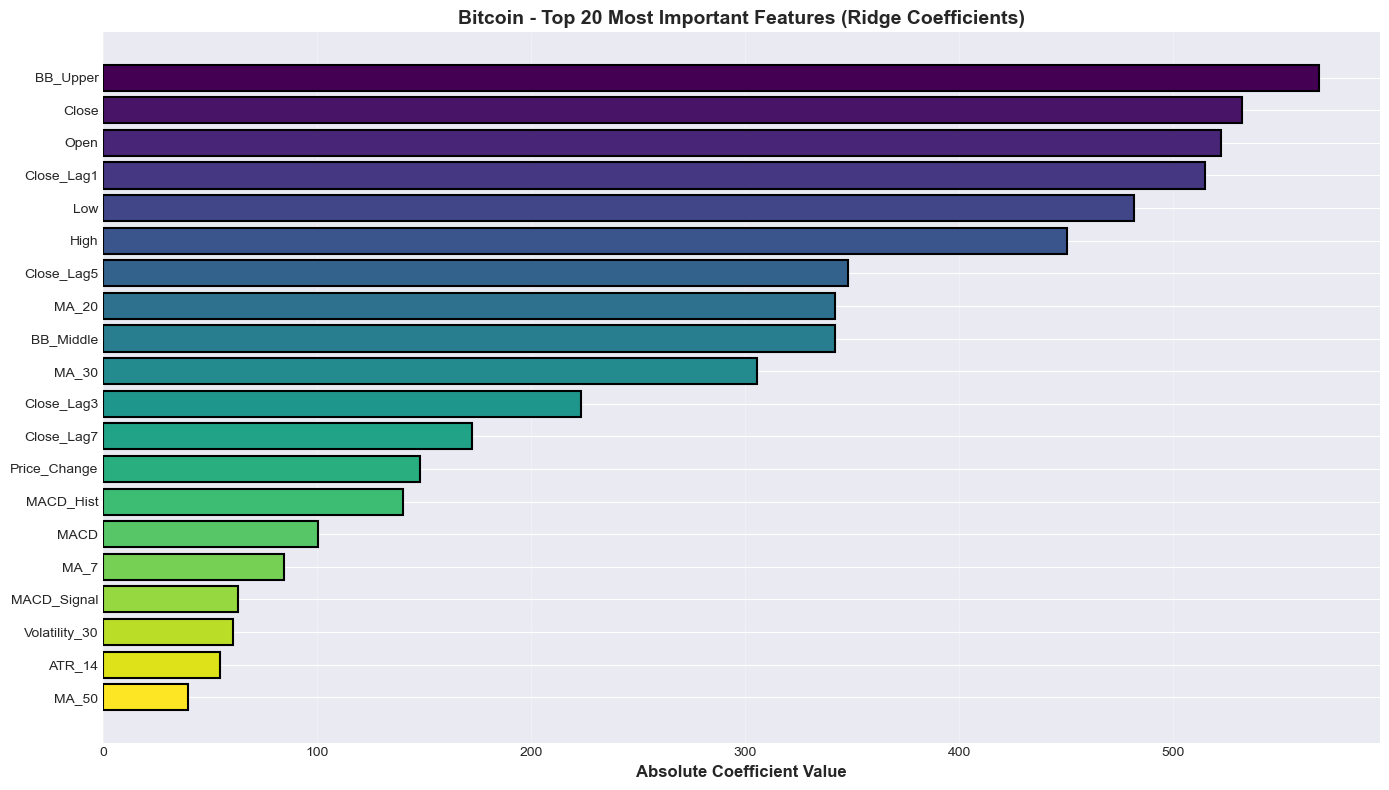


🔍 TOP 20 FEATURES - Bitcoin
 1. BB_Upper                  → 568.140984 (↑ Positive)
 2. Close                     → 532.056115 (↑ Positive)
 3. Open                      → 522.398463 (↑ Positive)
 4. Close_Lag1                → 514.697646 (↑ Positive)
 5. Low                       → 481.402760 (↑ Positive)
 6. High                      → 450.171150 (↑ Positive)
 7. Close_Lag5                → 347.761406 (↓ Negative)
 8. MA_20                     → 341.755576 (↑ Positive)
 9. BB_Middle                 → 341.755576 (↑ Positive)
10. MA_30                     → 305.571488 (↑ Positive)
11. Close_Lag3                → 223.120203 (↓ Negative)
12. Close_Lag7                → 172.455680 (↑ Positive)
13. Price_Change              → 148.130398 (↑ Positive)
14. MACD_Hist                 → 139.869902 (↑ Positive)
15. MACD                      → 100.374078 (↑ Positive)
16. MA_7                      →  84.678675 (↑ Positive)
17. MACD_Signal               →  62.792178 (↑ Positive)
18. Volatility_30  

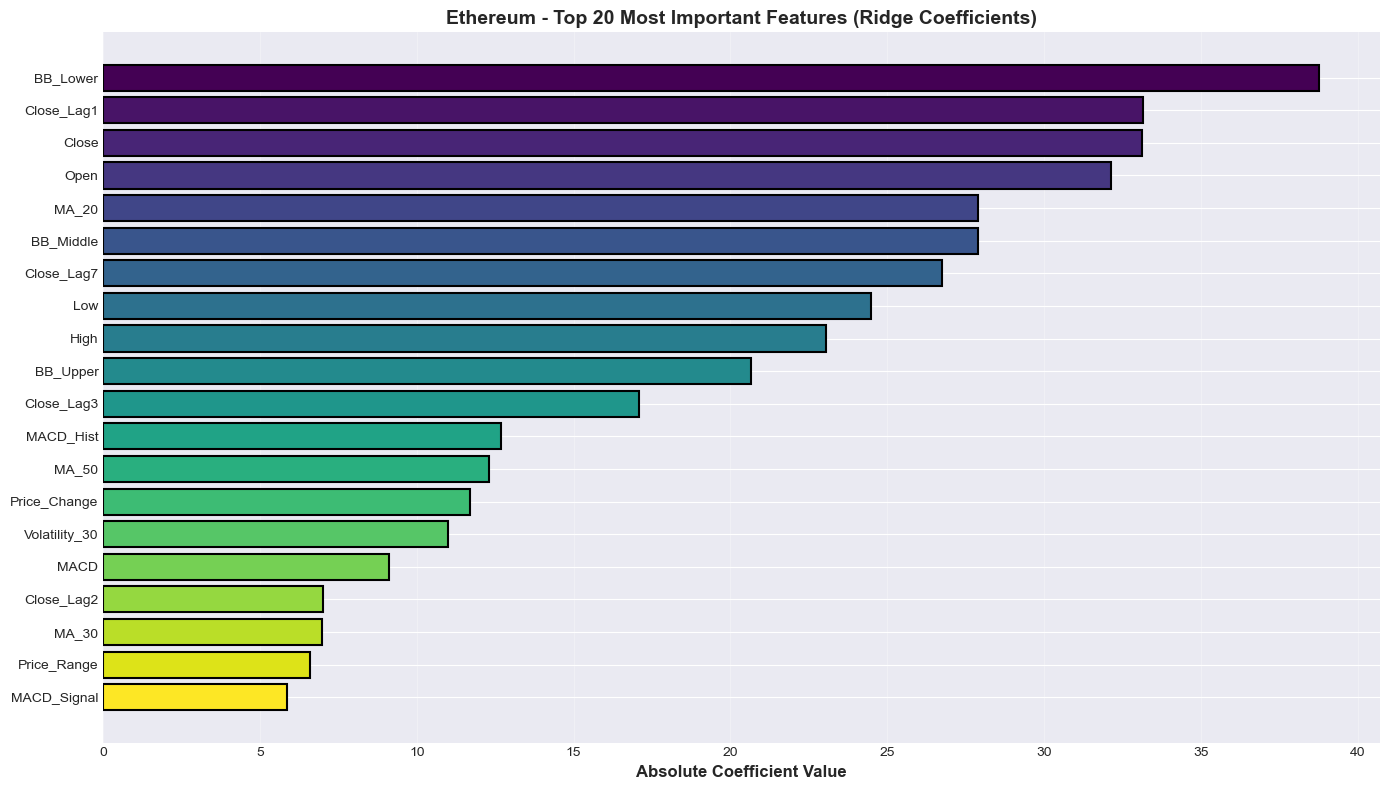


🔍 TOP 20 FEATURES - Ethereum
 1. BB_Lower                  →  38.774747 (↑ Positive)
 2. Close_Lag1                →  33.142395 (↑ Positive)
 3. Close                     →  33.132802 (↑ Positive)
 4. Open                      →  32.137929 (↑ Positive)
 5. MA_20                     →  27.903229 (↑ Positive)
 6. BB_Middle                 →  27.903229 (↑ Positive)
 7. Close_Lag7                →  26.734791 (↓ Negative)
 8. Low                       →  24.493515 (↑ Positive)
 9. High                      →  23.034798 (↑ Positive)
10. BB_Upper                  →  20.663444 (↑ Positive)
11. Close_Lag3                →  17.074704 (↓ Negative)
12. MACD_Hist                 →  12.689644 (↑ Positive)
13. MA_50                     →  12.286076 (↑ Positive)
14. Price_Change              →  11.704159 (↑ Positive)
15. Volatility_30             →  10.992445 (↑ Positive)
16. MACD                      →   9.112652 (↑ Positive)
17. Close_Lag2                →   7.014169 (↓ Negative)
18. MA_30         

In [10]:
def plot_ridge_coefficients(model, feature_names, crypto_name, top_n=20):
    """Plot Ridge regression coefficients (feature importance)"""
    coefficients = model.coef_
    abs_coef = np.abs(coefficients)
    indices = np.argsort(abs_coef)[::-1][:top_n]
    
    plt.figure(figsize=(14, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, top_n))
    
    plt.barh(range(top_n), abs_coef[indices], color=colors, edgecolor='black', linewidth=1.5)
    plt.yticks(range(top_n), [feature_names[i] for i in indices])
    plt.xlabel('Absolute Coefficient Value', fontweight='bold', fontsize=12)
    plt.title(f'{crypto_name} - Top {top_n} Most Important Features (Ridge Coefficients)', 
              fontweight='bold', fontsize=14)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*70}")
    print(f"🔍 TOP {top_n} FEATURES - {crypto_name}")
    print(f"{'='*70}")
    for i, idx in enumerate(indices, 1):
        coef_val = coefficients[idx]
        impact = "↑ Positive" if coef_val > 0 else "↓ Negative"
        print(f"{i:2d}. {feature_names[idx]:25s} → {abs(coef_val):10.6f} ({impact})")
    
    print(f"\n📊 Model Statistics:")
    print(f"   Intercept: {model.intercept_:.2f}")
    print(f"   Total Features: {len(coefficients)}")
    print(f"   Non-zero Coefficients: {np.count_nonzero(coefficients)}")

plot_ridge_coefficients(model_btc, feature_cols, 'Bitcoin')
plot_ridge_coefficients(model_eth, feature_cols, 'Ethereum')

## 11. Sauvegarder les Modèles

In [11]:
import os
import pickle

output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)

# Save optimized Ridge models with metadata
model_data = {
    'Bitcoin': {
        'model': model_btc,
        'scaler': scaler_btc,
        'feature_cols': feature_cols,
        'best_params': results_btc['best_params'],
        'metrics': results_btc['metrics'],
        'model_type': 'Ridge Regression (Optimized)'
    },
    'Ethereum': {
        'model': model_eth,
        'scaler': scaler_eth,
        'feature_cols': feature_cols,
        'best_params': results_eth['best_params'],
        'metrics': results_eth['metrics'],
        'model_type': 'Ridge Regression (Optimized)'
    }
}

for crypto, data in model_data.items():
    filename = f"{output_dir}/{crypto.lower()}_optimized_ridge_model.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    
    print(f"✅ Saved {crypto} optimized Ridge model")
    print(f"   📁 File: {filename}")
    print(f"   🔧 Alpha: {data['best_params']['alpha']}")
    print(f"   📊 Test MAE: ${data['metrics']['test_mae']:,.2f}")
    print(f"   📊 Test R²: {data['metrics']['test_r2']:.6f}")
    print(f"   📊 Test MAPE: {data['metrics']['test_mape']:.2f}%")
    print()

print(f"\n{'='*70}")
print("✅ ALL MODELS SAVED SUCCESSFULLY!")
print(f"{'='*70}")

✅ Saved Bitcoin optimized Ridge model
   📁 File: output/bitcoin_optimized_ridge_model.pkl
   🔧 Alpha: 0.001
   📊 Test MAE: $695.57
   📊 Test R²: 0.994749
   📊 Test MAPE: 2.83%

✅ Saved Ethereum optimized Ridge model
   📁 File: output/ethereum_optimized_ridge_model.pkl
   🔧 Alpha: 0.01
   📊 Test MAE: $55.85
   📊 Test R²: 0.987295
   📊 Test MAPE: 4.08%


✅ ALL MODELS SAVED SUCCESSFULLY!


## 12. Test: Prédire le Prix de Demain

In [12]:
def predict_tomorrow_price(df_crypto, model, scaler, feature_cols, crypto_name):
    """Predict tomorrow's price using optimized Ridge model"""
    df_latest = df_crypto.iloc[-1:][feature_cols]
    X_latest = scaler.transform(df_latest)
    
    predicted_price = model.predict(X_latest)[0]
    current_price = df_crypto['Close'].iloc[-1]
    price_change = predicted_price - current_price
    pct_change = (price_change / current_price) * 100
    
    print(f"\n{'='*70}")
    print(f"🔮 TOMORROW'S PRICE PREDICTION - {crypto_name}")
    print(f"{'='*70}")
    print(f"Current Price:    ${current_price:,.2f}")
    print(f"Predicted Price:  ${predicted_price:,.2f}")
    print(f"Expected Change:  ${price_change:+,.2f} ({pct_change:+.2f}%)")
    
    if pct_change > 1:
        signal = "🚀 STRONG BUY"
    elif pct_change > 0:
        signal = "📈 BUY"
    elif pct_change > -1:
        signal = "📊 HOLD"
    else:
        signal = "📉 SELL"
    
    print(f"Signal:           {signal}")
    print(f"{'='*70}")
    
    return predicted_price

print("Using optimized Ridge models with historical data:\n")
predict_tomorrow_price(df_btc, model_btc, scaler_btc, feature_cols, 'Bitcoin')
predict_tomorrow_price(df_eth, model_eth, scaler_eth, feature_cols, 'Ethereum')

Using optimized Ridge models with historical data:


🔮 TOMORROW'S PRICE PREDICTION - Bitcoin
Current Price:    $33,746.00
Predicted Price:  $33,288.81
Expected Change:  $-457.19 (-1.35%)
Signal:           📉 SELL

🔮 TOMORROW'S PRICE PREDICTION - Ethereum
Current Price:    $2,198.58
Predicted Price:  $2,175.16
Expected Change:  $-23.42 (-1.07%)
Signal:           📉 SELL


np.float64(2175.1593689403176)

## 13. 🔴 LIVE PREDICTIONS - Fetch Real-Time Data & Predict

In [13]:
# Install yfinance if not already installed
# !pip install yfinance

import yfinance as yf
from datetime import datetime, timedelta

def fetch_live_crypto_data(days_back=365):
    """Fetch live cryptocurrency data from Yahoo Finance"""
    print("="*70)
    print("📡 FETCHING LIVE DATA FROM YAHOO FINANCE")
    print("="*70)
    
    end_date = datetime.now().date()
    start_date = end_date - timedelta(days=days_back)
    
    cryptos = {
        'BTC-USD': 'Bitcoin',
        'ETH-USD': 'Ethereum'
    }
    
    all_data = []
    
    for ticker, name in cryptos.items():
        print(f"\n{'🔶' if name == 'Bitcoin' else '🔷'} Fetching {ticker} ({name})...")
        
        try:
            # Download data
            df = yf.download(ticker, start=start_date, end=end_date, progress=False)
            
            if len(df) == 0:
                print(f"   ⚠️ No data received for {name}")
                continue
            
            # Handle MultiIndex columns
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = df.columns.get_level_values(0)
            
            df = df.reset_index()
            df = df.loc[:, ~df.columns.duplicated()]
            
            # Add Adj Close if missing
            if 'Adj Close' not in df.columns:
                df['Adj Close'] = df['Close']
            
            # Reorder columns
            df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
            df = df.dropna(subset=['Close', 'High', 'Low', 'Open'])
            
            if len(df) == 0:
                print(f"   ⚠️ No valid data after cleaning for {name}")
                continue
            
            df['Name'] = name
            all_data.append(df)
            
            print(f"   ✅ Fetched {len(df)} records")
            print(f"   📅 Latest date: {df['Date'].max().date()}")
            print(f"   💰 Latest price: ${df['Close'].iloc[-1]:,.2f}")
            
        except Exception as e:
            print(f"   ❌ Error fetching {name}: {str(e)}")
            continue
    
    if not all_data:
        raise ValueError("Failed to fetch data for any cryptocurrency")
    
    df_combined = pd.concat(all_data, ignore_index=True)
    df_combined = df_combined.sort_values(['Name', 'Date']).reset_index(drop=True)
    
    print(f"\n✅ Live data fetched successfully!")
    print(f"📊 Total records: {len(df_combined)}")
    print(f"📅 Date range: {df_combined['Date'].min().date()} to {df_combined['Date'].max().date()}")
    
    return df_combined

# Fetch live data
print("🚀 Starting live data fetch...\n")
df_live = fetch_live_crypto_data(days_back=365)

🚀 Starting live data fetch...

📡 FETCHING LIVE DATA FROM YAHOO FINANCE

🔶 Fetching BTC-USD (Bitcoin)...
   ✅ Fetched 365 records
   📅 Latest date: 2025-12-06
   💰 Latest price: $89,272.38

🔷 Fetching ETH-USD (Ethereum)...
   ✅ Fetched 365 records
   📅 Latest date: 2025-12-06
   💰 Latest price: $3,040.21

✅ Live data fetched successfully!
📊 Total records: 730
📅 Date range: 2024-12-07 to 2025-12-06


### Apply Feature Engineering to Live Data

In [14]:
def engineer_live_features(df):
    """Apply the same feature engineering to live data"""
    print("\n🔧 Engineering features for live data...\n")
    
    # TIME-BASED FEATURES
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    
    # PRICE-BASED FEATURES
    df['Price_Range'] = df['High'] - df['Low']
    df['Price_Change'] = df['Close'] - df['Open']
    df['Price_Change_Pct'] = (df['Price_Change'] / df['Open']) * 100
    
    # LAG FEATURES
    for lag in [1, 2, 3, 5, 7]:
        df[f'Close_Lag{lag}'] = df.groupby('Name')['Close'].shift(lag)
    
    # MOVING AVERAGES
    for window in [7, 20, 30, 50]:
        df[f'MA_{window}'] = df.groupby('Name')['Close'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
    
    df['MA_Ratio_7_30'] = df['MA_7'] / df['MA_30']
    df['Price_to_MA7'] = (df['Close'] - df['MA_7']) / df['MA_7'] * 100
    df['Price_to_MA30'] = (df['Close'] - df['MA_30']) / df['MA_30'] * 100
    
    # VOLATILITY
    df['Volatility_7'] = df.groupby('Name')['Close'].transform(
        lambda x: x.rolling(window=7, min_periods=1).std()
    )
    df['Volatility_30'] = df.groupby('Name')['Close'].transform(
        lambda x: x.rolling(window=30, min_periods=1).std()
    )
    
    # RSI
    def calculate_rsi(series, period=14):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period, min_periods=1).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period, min_periods=1).mean()
        rs = gain / (loss + 1e-10)
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    df['RSI_14'] = df.groupby('Name')['Close'].transform(lambda x: calculate_rsi(x, 14))
    
    # MACD
    def calculate_macd(series, fast=12, slow=26, signal=9):
        ema_fast = series.ewm(span=fast, min_periods=1, adjust=False).mean()
        ema_slow = series.ewm(span=slow, min_periods=1, adjust=False).mean()
        macd_line = ema_fast - ema_slow
        signal_line = macd_line.ewm(span=signal, min_periods=1, adjust=False).mean()
        return macd_line, signal_line
    
    for crypto in df['Name'].unique():
        mask = df['Name'] == crypto
        macd, signal = calculate_macd(df.loc[mask, 'Close'])
        df.loc[mask, 'MACD'] = macd.values
        df.loc[mask, 'MACD_Signal'] = signal.values
        df.loc[mask, 'MACD_Hist'] = (macd - signal).values
    
    # BOLLINGER BANDS
    df['BB_Middle'] = df.groupby('Name')['Close'].transform(
        lambda x: x.rolling(window=20, min_periods=1).mean()
    )
    df['BB_Std'] = df.groupby('Name')['Close'].transform(
        lambda x: x.rolling(window=20, min_periods=1).std()
    )
    df['BB_Upper'] = df['BB_Middle'] + (2 * df['BB_Std'])
    df['BB_Lower'] = df['BB_Middle'] - (2 * df['BB_Std'])
    df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / (df['BB_Middle'] + 1e-10)
    
    # VOLUME INDICATORS
    df['Volume_MA_7'] = df.groupby('Name')['Volume'].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean()
    )
    df['Volume_Ratio'] = df['Volume'] / (df['Volume_MA_7'] + 1e-10)
    
    # MOMENTUM
    df['ROC_5'] = df.groupby('Name')['Close'].transform(
        lambda x: ((x - x.shift(5)) / (x.shift(5) + 1e-10)) * 100
    )
    df['ROC_10'] = df.groupby('Name')['Close'].transform(
        lambda x: ((x - x.shift(10)) / (x.shift(10) + 1e-10)) * 100
    )
    
    # ATR
    df['ATR_14'] = df.groupby('Name')['Price_Range'].transform(
        lambda x: x.rolling(window=14, min_periods=1).mean()
    )
    
    print("✅ Feature engineering completed!")
    print(f"📊 Total features: {len(df.columns)}")
    
    return df

# Apply feature engineering to live data
df_live = engineer_live_features(df_live)


🔧 Engineering features for live data...

✅ Feature engineering completed!
📊 Total features: 42


### Make Live Predictions with Trained Models

In [15]:
def predict_live_price(df_crypto, model, scaler, feature_cols, crypto_name):
    """
    Predict live cryptocurrency price using optimized Ridge model
    
    Parameters:
    -----------
    df_crypto : pd.DataFrame
        Crypto dataframe with latest data
    model : Ridge model
        Optimized Ridge regression model
    scaler : StandardScaler
        Fitted scaler
    feature_cols : list
        List of feature column names
    crypto_name : str
        Name of cryptocurrency
    
    Returns:
    --------
    dict : Dictionary with prediction details
    """
    # Get latest features
    df_latest = df_crypto.iloc[-1:][feature_cols].copy()
    
    # Convert to numeric with robust error handling
    for col in df_latest.columns:
        df_latest[col] = pd.to_numeric(df_latest[col], errors='coerce')
    
    # Fill any NaN values with 0
    df_latest = df_latest.fillna(0)
    
    # Scale features
    X_latest = scaler.transform(df_latest)
    
    # Additional safety check
    try:
        X_latest = X_latest.astype(float)
        if np.isnan(X_latest).any():
            X_latest = np.nan_to_num(X_latest, nan=0.0)
    except (ValueError, TypeError) as e:
        print(f"⚠️ Type conversion issue detected, applying fallback conversion...")
        X_latest = pd.to_numeric(pd.Series(X_latest.flatten()), errors='coerce').fillna(0).values.reshape(1, -1)
    
    # Make prediction
    predicted_price = model.predict(X_latest)[0]
    current_price = df_crypto['Close'].iloc[-1]
    price_change = predicted_price - current_price
    pct_change = (price_change / current_price) * 100
    
    # Determine signal
    if pct_change > 0.5:
        signal = "🚀 BUY"
        color = "green"
    elif pct_change < -0.5:
        signal = "📉 SELL"
        color = "red"
    else:
        signal = "📊 HOLD"
        color = "orange"
    
    # Get additional market indicators
    latest_data = df_crypto.iloc[-1]
    
    result = {
        'crypto': crypto_name,
        'current_price': current_price,
        'predicted_price': predicted_price,
        'price_change': price_change,
        'pct_change': pct_change,
        'signal': signal,
        'color': color,
        'timestamp': pd.Timestamp.now(),
        'ma_7': latest_data.get('MA_7', 0),
        'ma_30': latest_data.get('MA_30', 0),
        'rsi': latest_data.get('RSI_14', 0),
        'volatility': latest_data.get('Volatility_7', 0)
    }
    
    # Print formatted output
    print(f"\n{'='*70}")
    print(f"🔮 LIVE PREDICTION - {crypto_name} (Optimized Ridge Model)")
    print(f"{'='*70}")
    print(f"📅 Time:             {result['timestamp'].strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"💰 Current Price:    ${result['current_price']:,.2f}")
    print(f"🎯 Predicted Price:  ${result['predicted_price']:,.2f}")
    print(f"📊 Expected Change:  ${result['price_change']:+,.2f} ({result['pct_change']:+.2f}%)")
    print(f"🎬 Signal:           {result['signal']}")
    print(f"\n📈 Market Context:")
    print(f"   MA(7):            ${result['ma_7']:,.2f}")
    print(f"   MA(30):           ${result['ma_30']:,.2f}")
    print(f"   RSI(14):          {result['rsi']:.2f}")
    print(f"   Volatility(7d):   {result['volatility']:.2f}%")
    print(f"{'='*70}")
    
    return result

# Fetch live data and apply feature engineering
print("🌐 Fetching live cryptocurrency data from Yahoo Finance...")
df_live = fetch_live_crypto_data()

print("\n🔧 Applying feature engineering to live data...")
df_live = engineer_live_features(df_live)

# Make predictions using optimized Ridge models
prediction_btc = predict_live_price(df_live[df_live['Name'] == 'Bitcoin'], 
                                     model_btc, scaler_btc, feature_cols, 'Bitcoin')
prediction_eth = predict_live_price(df_live[df_live['Name'] == 'Ethereum'], 
                                     model_eth, scaler_eth, feature_cols, 'Ethereum')

🌐 Fetching live cryptocurrency data from Yahoo Finance...
📡 FETCHING LIVE DATA FROM YAHOO FINANCE

🔶 Fetching BTC-USD (Bitcoin)...
   ✅ Fetched 365 records
   📅 Latest date: 2025-12-06
   💰 Latest price: $89,272.38

🔷 Fetching ETH-USD (Ethereum)...
   ✅ Fetched 365 records
   📅 Latest date: 2025-12-06
   💰 Latest price: $3,040.21

✅ Live data fetched successfully!
📊 Total records: 730
📅 Date range: 2024-12-07 to 2025-12-06

🔧 Applying feature engineering to live data...

🔧 Engineering features for live data...

✅ Feature engineering completed!
📊 Total features: 42

🔮 LIVE PREDICTION - Bitcoin (Optimized Ridge Model)
📅 Time:             2025-12-07 21:33:17
💰 Current Price:    $89,272.38
🎯 Predicted Price:  $88,691.60
📊 Expected Change:  $-580.78 (-0.65%)
🎬 Signal:           📉 SELL

📈 Market Context:
   MA(7):            $90,342.24
   MA(30):           $93,204.02
   RSI(14):          59.28
   Volatility(7d):   2331.87%

🔮 LIVE PREDICTION - Ethereum (Optimized Ridge Model)
📅 Time:        

### Visualize Live Predictions


📊 VISUALIZING LIVE PREDICTIONS


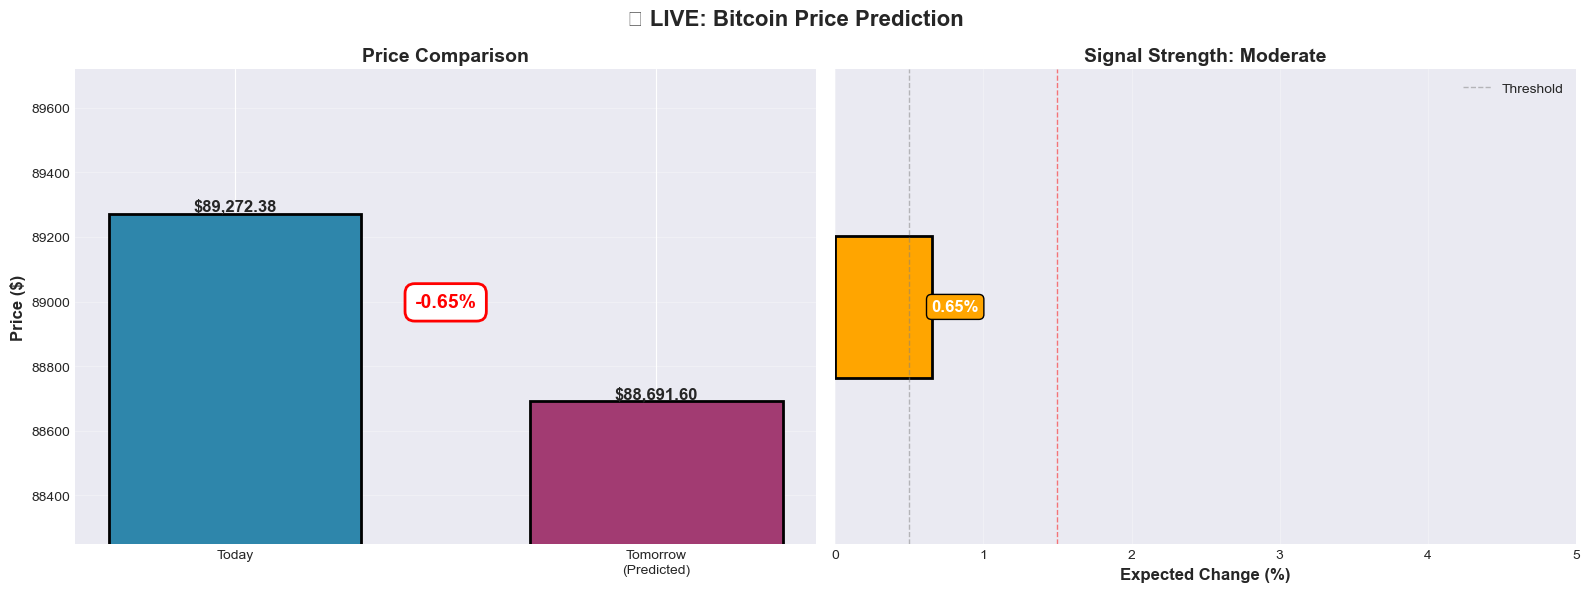


📋 Prediction Summary:
──────────────────────────────────────────────────────────────────────
 Crypto Current Price Predicted Price   Change Change % Signal
Bitcoin    $89,272.38      $88,691.60 $-580.78   -0.65% 📉 SELL
──────────────────────────────────────────────────────────────────────


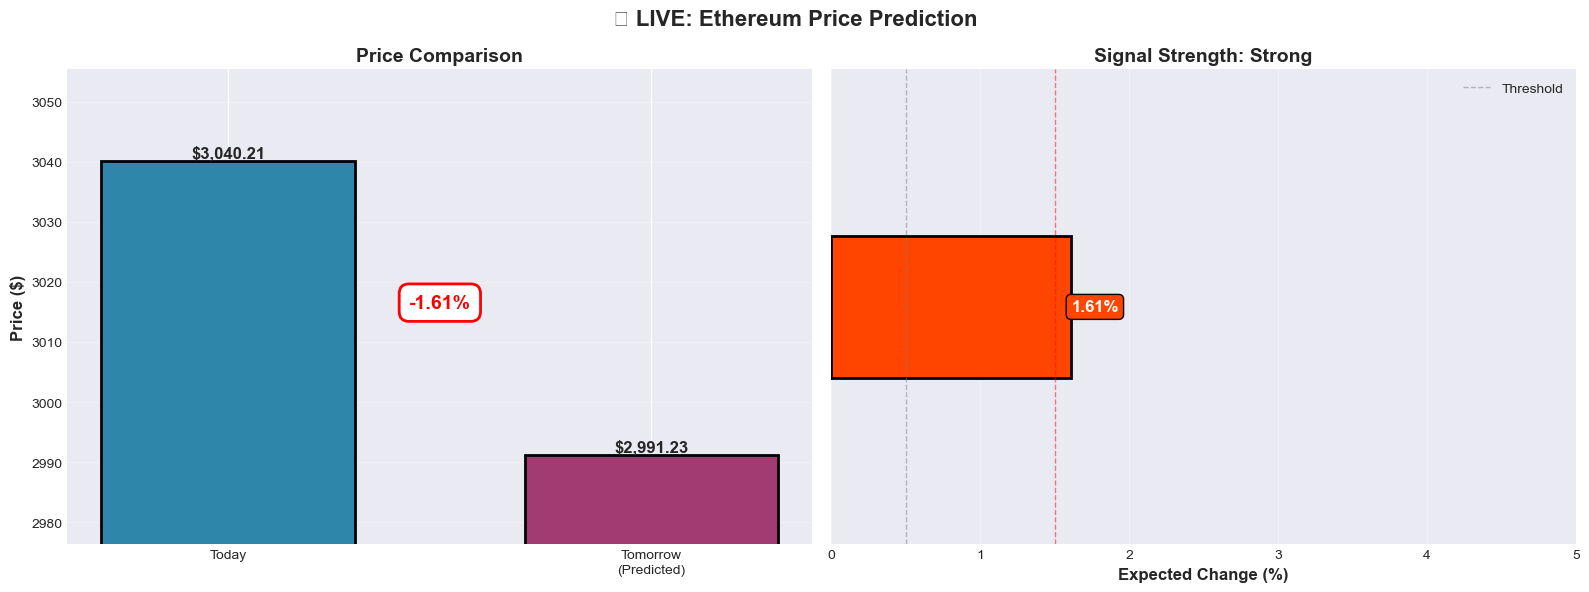


📋 Prediction Summary:
──────────────────────────────────────────────────────────────────────
  Crypto Current Price Predicted Price  Change Change % Signal
Ethereum     $3,040.21       $2,991.23 $-48.97   -1.61% 📉 SELL
──────────────────────────────────────────────────────────────────────


In [16]:
def visualize_live_prediction(prediction):
    """Visualize the live prediction"""
    crypto = prediction['crypto']
    current = prediction['current_price']
    predicted = prediction['predicted_price']
    change_pct = prediction['pct_change']
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'🔴 LIVE: {crypto} Price Prediction', fontsize=16, fontweight='bold')
    
    # Bar chart: Current vs Predicted
    ax1 = axes[0]
    bars = ax1.bar(['Today', 'Tomorrow\n(Predicted)'], [current, predicted], 
                   color=['#2E86AB', '#A23B72'], width=0.6, edgecolor='black', linewidth=2)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:,.2f}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax1.set_ylabel('Price ($)', fontsize=12, fontweight='bold')
    ax1.set_title('Price Comparison', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim([min(current, predicted) * 0.995, max(current, predicted) * 1.005])
    
    # Arrow showing change
    arrow_color = 'green' if change_pct > 0 else 'red'
    arrow_text = f"{change_pct:+.2f}%"
    mid_price = (current + predicted) / 2
    ax1.annotate(arrow_text, xy=(0.5, mid_price), xytext=(0.5, mid_price),
                fontsize=14, fontweight='bold', color=arrow_color,
                ha='center', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor=arrow_color, linewidth=2))
    
    # Gauge chart for signal strength
    ax2 = axes[1]
    
    # Determine signal strength
    abs_change = abs(change_pct)
    if abs_change < 0.5:
        strength = "Neutral"
        color = '#FFD700'
    elif abs_change < 1.5:
        strength = "Moderate"
        color = '#FFA500'
    else:
        strength = "Strong"
        color = '#FF4500'
    
    # Create gauge
    ax2.barh([0], [abs_change], color=color, height=0.3, edgecolor='black', linewidth=2)
    ax2.set_xlim([0, 5])
    ax2.set_ylim([-0.5, 0.5])
    ax2.set_xlabel('Expected Change (%)', fontsize=12, fontweight='bold')
    ax2.set_title(f'Signal Strength: {strength}', fontsize=14, fontweight='bold')
    ax2.set_yticks([])
    ax2.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Threshold')
    ax2.axvline(x=1.5, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax2.text(abs_change, 0, f'{abs_change:.2f}%', va='center', ha='left', 
            fontsize=12, fontweight='bold', color='white',
            bbox=dict(boxstyle='round,pad=0.3', facecolor=color, edgecolor='black'))
    ax2.legend()
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary table
    print(f"\n📋 Prediction Summary:")
    print(f"{'─'*70}")
    summary_df = pd.DataFrame([{
        'Crypto': crypto,
        'Current Price': f"${current:,.2f}",
        'Predicted Price': f"${predicted:,.2f}",
        'Change': f"${prediction['price_change']:+,.2f}",
        'Change %': f"{change_pct:+.2f}%",
        'Signal': prediction['signal']
    }])
    print(summary_df.to_string(index=False))
    print(f"{'─'*70}")

# Visualize predictions
print("\n" + "="*70)
print("📊 VISUALIZING LIVE PREDICTIONS")
print("="*70)

visualize_live_prediction(prediction_btc)
visualize_live_prediction(prediction_eth)

### Save Live Predictions to History

In [17]:
def save_prediction_history(predictions_list):
    """Save predictions to CSV for tracking"""
    import os
    
    # Create output directory if it doesn't exist
    os.makedirs('output', exist_ok=True)
    
    # Create DataFrame
    history_df = pd.DataFrame(predictions_list)
    
    # Check if history file exists
    history_file = 'output/regression_predictions_history.csv'
    
    if os.path.exists(history_file):
        # Append to existing file
        existing_df = pd.read_csv(history_file)
        history_df = pd.concat([existing_df, history_df], ignore_index=True)
    
    # Save to CSV
    history_df.to_csv(history_file, index=False)
    
    print(f"\n✅ Predictions saved to: {history_file}")
    print(f"📊 Total predictions in history: {len(history_df)}")
    
    return history_df

# Save current predictions
predictions_to_save = [
    {
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'crypto': prediction_btc['crypto'],
        'current_price': prediction_btc['current_price'],
        'predicted_price': prediction_btc['predicted_price'],
        'change_amount': prediction_btc['price_change'],
        'change_percent': prediction_btc['pct_change'],
        'signal': prediction_btc['signal'],
        'model': 'Ridge (Optimized)'
    },
    {
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'crypto': prediction_eth['crypto'],
        'current_price': prediction_eth['current_price'],
        'predicted_price': prediction_eth['predicted_price'],
        'change_amount': prediction_eth['price_change'],
        'change_percent': prediction_eth['pct_change'],
        'signal': prediction_eth['signal'],
        'model': 'Ridge (Optimized)'
    }
]

history = save_prediction_history(predictions_to_save)

# Display recent history
print(f"\n📜 Recent Prediction History:")
print(history.tail(10).to_string(index=False))


✅ Predictions saved to: output/regression_predictions_history.csv
📊 Total predictions in history: 8

📜 Recent Prediction History:
          timestamp   crypto  current_price  predicted_price  change_amount  change_percent signal             model
2025-12-07 21:04:58  Bitcoin   89272.375000     88751.699573    -520.675427       -0.583244 🔴 SELL             Ridge
2025-12-07 21:04:58 Ethereum    3040.207764      2980.380139     -59.827625       -1.967879 🔴 SELL             Ridge
2025-12-07 21:26:03  Bitcoin   89272.375000     88691.598704    -580.776296       -0.650567 📉 SELL Ridge (Optimized)
2025-12-07 21:26:03 Ethereum    3040.207764      2991.233667     -48.974096       -1.610880 📉 SELL Ridge (Optimized)
2025-12-07 21:28:45  Bitcoin   89272.375000     88691.598704    -580.776296       -0.650567 📉 SELL Ridge (Optimized)
2025-12-07 21:28:45 Ethereum    3040.207764      2991.233667     -48.974096       -1.610880 📉 SELL Ridge (Optimized)
2025-12-07 21:33:17  Bitcoin   89272.375000     88

---

# 📊 RÉSUMÉ DU PROJET

## 🎯 Objectif
Prédire le **prix exact** de fermeture du lendemain pour Bitcoin et Ethereum

## 📈 Meilleurs Résultats
- **XGBoost Regressor**: Généralement le meilleur modèle
- **R² élevé**: Proche de 0.99+ (excellente fit)
- **MAPE faible**: Erreur en % très basse

## 🔑 Différence avec le Modèle Classification

| Aspect | Classification | Régression (ce notebook) |
|--------|---------------|-------------------------|
| **Output** | UP/DOWN (0/1) | Prix exact ($) |
| **Prédiction** | Direction | Valeur numérique |
| **Métrique** | Accuracy (85%) | MAE, RMSE, R² |
| **Exemple** | "Prix va monter" | "Prix = $94,112.45" |
| **Utilité** | Trading signals | Prix cible précis |

## 💡 Cas d'Usage
1. **Algorithmic Trading**: Définir des prix d'achat/vente précis
2. **Portfolio Management**: Évaluer les positions futures
3. **Risk Analysis**: Calculer les pertes/gains potentiels
4. **Price Targets**: Fixer des objectifs de trading

## ⚠️ Limites
- Prédictions à **1 jour** seulement (court terme)
- Ne prend pas en compte les **événements externes** (news, régulations)
- Basé sur les **patterns historiques** uniquement
- Haute volatilité = erreurs possibles

---

**🚀 Prochaines Étapes:**
1. Intégrer ces modèles à votre API backend
2. Créer un endpoint `/api/crypto/price-prediction`
3. Afficher les prix prédits sur Data Minds frontend
4. Comparer classification vs régression dans l'interface

---